In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import yaml
import ast

In [2]:
%run ./src/database.py
%run ./src/util.py
%run ./src/data_preprocessing.py
%run ./src/feature_engineering.py
%run ./src/visualisation.py

In [3]:
YAML_FILEPATHNAME = "./config.yaml"
PRE_CRUISE_DB = 0
POST_CRUISE_DB = 1

# Read yaml config and data

In [4]:
# Read YAML file
yaml_data = read_yaml(YAML_FILEPATHNAME)
DISPLAY_STUB = yaml_data['display_stub']
DATA_PATH = yaml_data['data_path']
TEST_SIZE = yaml_data['test_size']
RANDOM_STATE = yaml_data['random_state']
TARGET_VARIABLE = yaml_data['target_variable']
DB_INFO = yaml_data['databases']
COMPOSITE_FIELD_INFO = yaml_data['composite_fields_to_split']
ID_FIELDS = ast.literal_eval(yaml_data['ID_columns'])
DATETIME_FIELD_INFO = yaml_data['convert_obj_datetime']
MISSING_VAL_THRESHOLD =  yaml_data['pct_missing_threshold']
CONTINUOUS_VARIABLE = ast.literal_eval(yaml_data['continuous_variables'])
DIRTY_DATA_INFO = yaml_data['dirty_data_setting']
VALID_DATA_INFO = yaml_data['valid_data_setting']
NON_NUMERIC_COL = yaml_data['non_numeric_cols']
DATE_YYYY_INFO = yaml_data['convert_date_yyyy']

In [5]:
# Read Pre_cruise data
df_pre_cruise = db_read(DATA_PATH, DB_INFO[PRE_CRUISE_DB])

In [6]:
# Read Post_cruise data
df_post_cruise = db_read(DATA_PATH, DB_INFO[POST_CRUISE_DB])

# Preprocessing

In [7]:
# Merge Pre_cruise and Post_cruise to form df_cruise with Index as the key
df_cruise = db_merge_db (df_pre_cruise, df_post_cruise)

In [8]:
dp = DataProcessing(df_cruise, DISPLAY_STUB)

In [9]:
# Replace all np.nan to None
dp.replace_nan_None()

In [10]:
# Split composite field
dp.split_composite_field(COMPOSITE_FIELD_INFO)

In [11]:
# Remove IDs columns as in general they will have no predictive power
dp.rm_id_cols(ID_FIELDS)

In [12]:
# Convert fields with Object to Datetime
dp.obj_to_datetime(DATETIME_FIELD_INFO)

In [13]:
# Column pruning due to high missing values.
dp.rm_cols_high_missing(MISSING_VAL_THRESHOLD)

In [14]:
# Remove of rows from Target Variable 
dp.rm_rows_target_var(TARGET_VARIABLE)

In [15]:
# Removal of rows from Continuous variable which has missing value 
dp.remove_missing(CONTINUOUS_VARIABLE)

In [16]:
# Dirty Data Cleansing
dp.dirty_data_processing(DIRTY_DATA_INFO)

In [17]:
# Restriction of Column vales
dp.valid_data_processing(VALID_DATA_INFO)

In [18]:
# Label encode non-numeric categorical columns to get numeric values
dp.label_encoder(NON_NUMERIC_COL)

In [19]:
# Derive year from date column to enhance model efficiency, mitigate noise
dp.yyyy_from_date(DATE_YYYY_INFO)

In [20]:
# Get Dataframe
df_cruise = dp.get_dataframe()

# Feature Engineering

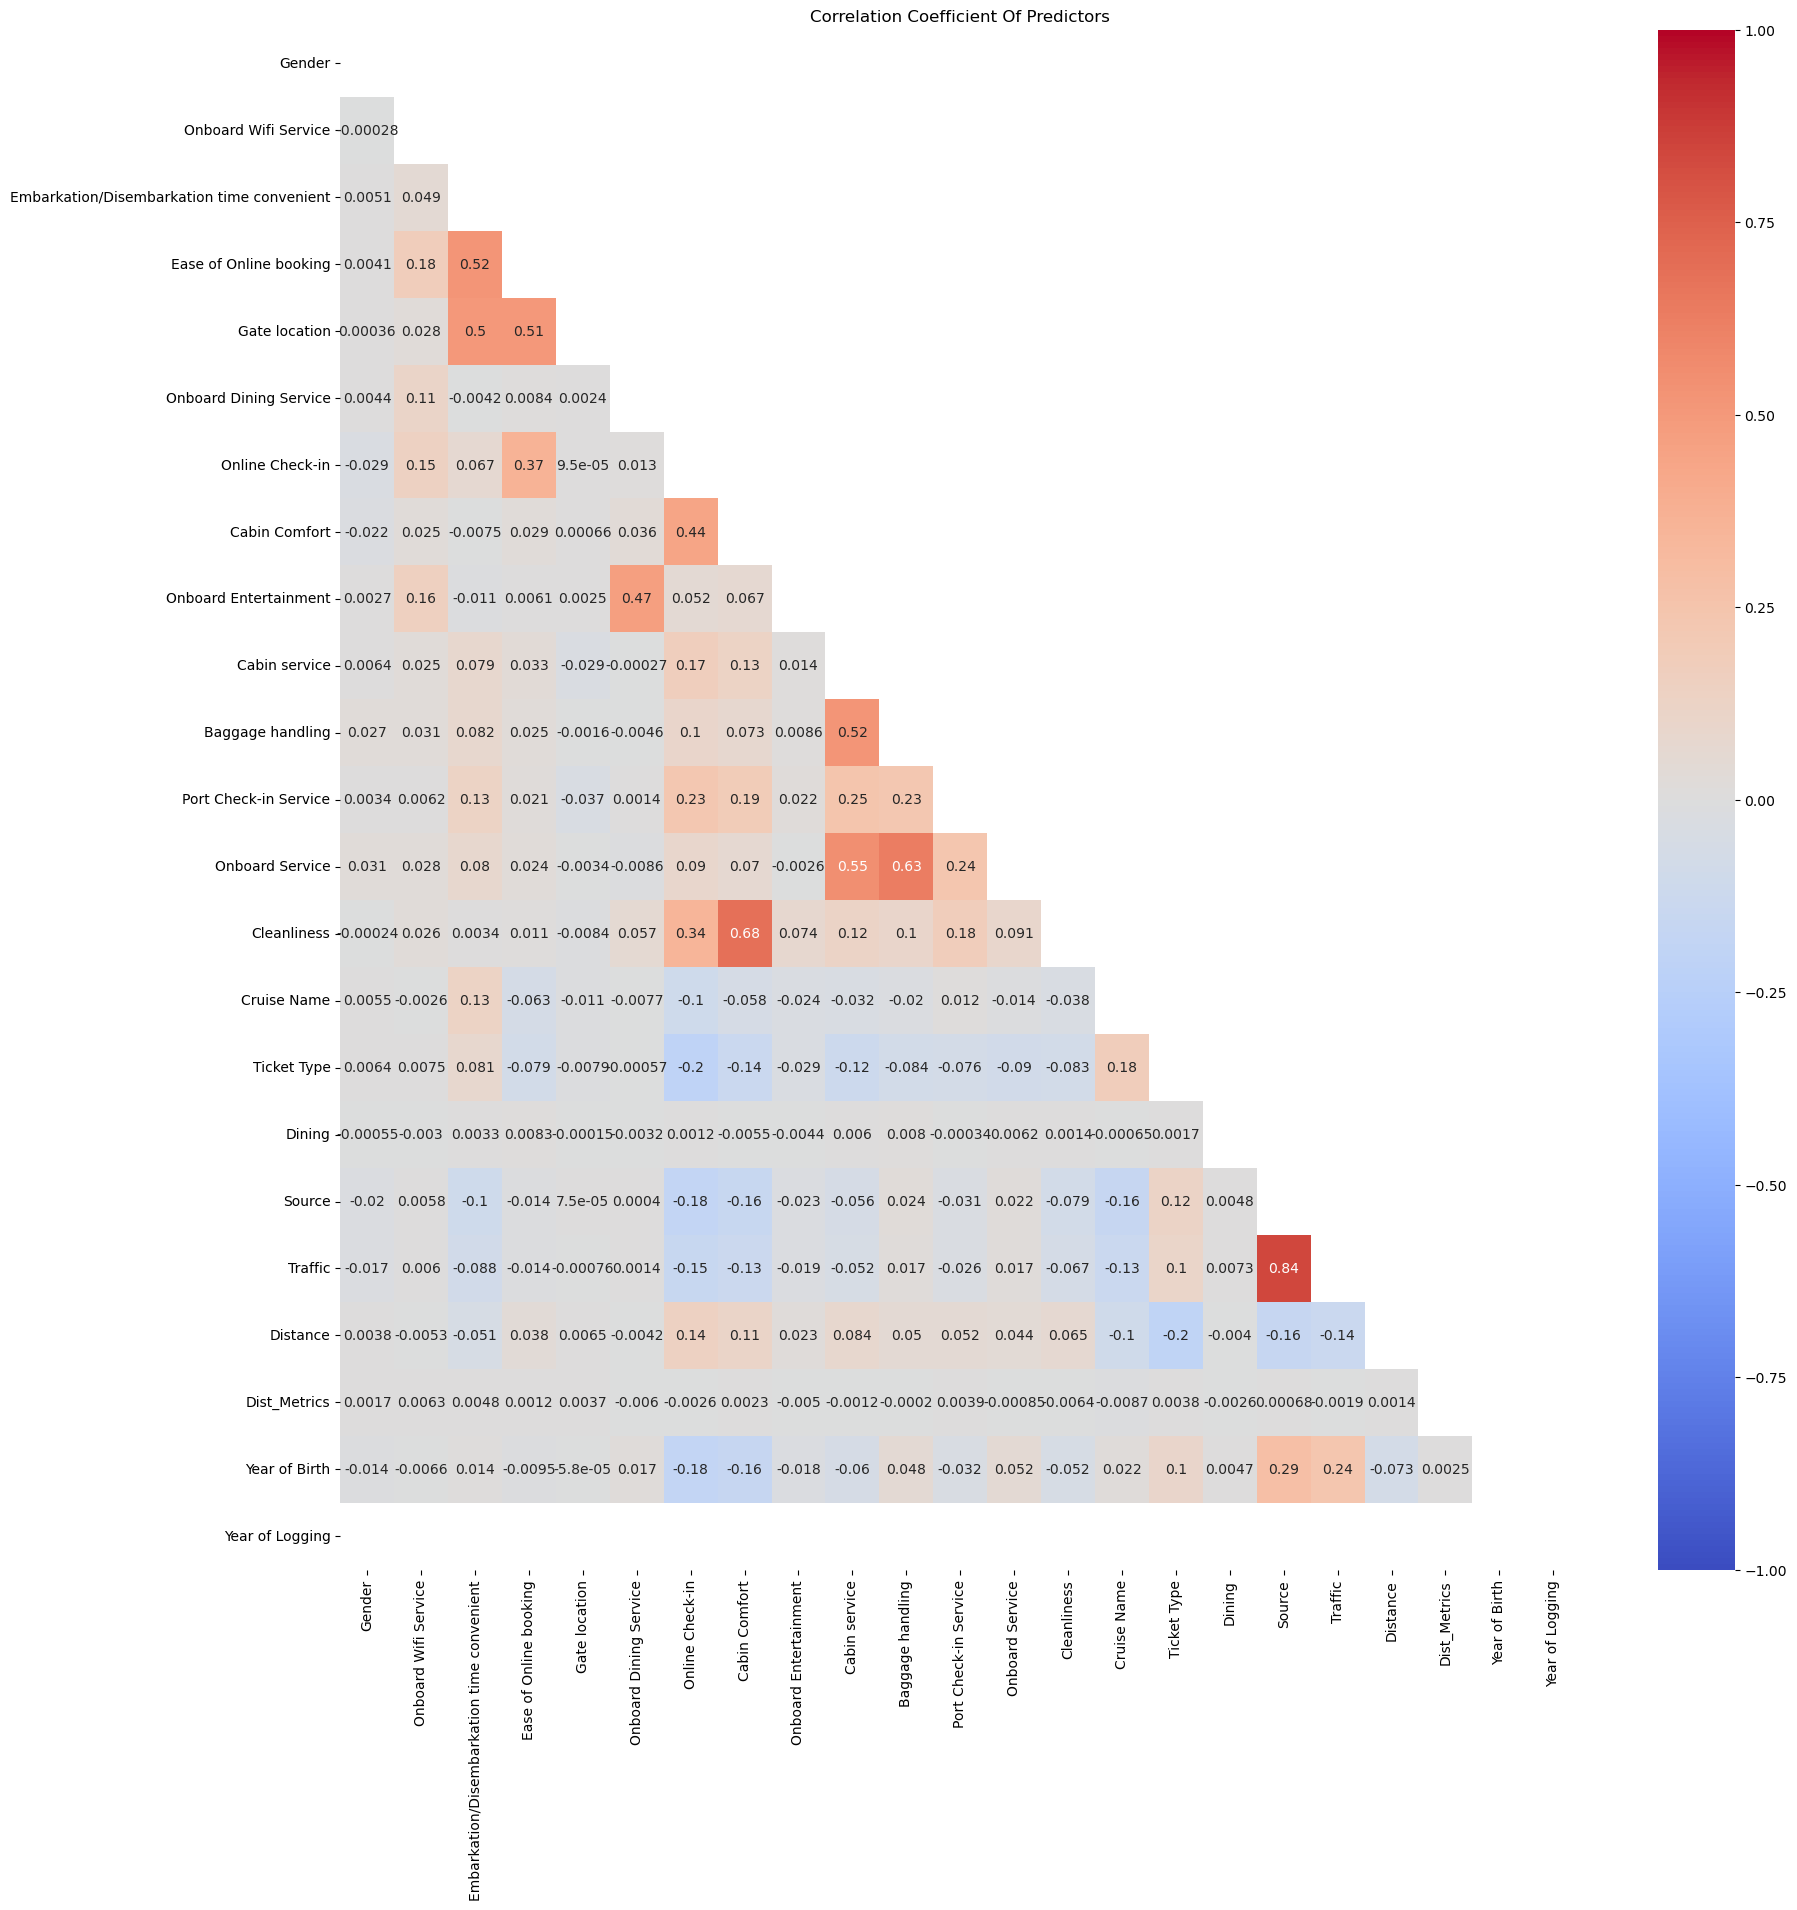

In [21]:
vs_plot_corr_chart(df_cruise)

In [ ]:
df_cruise.info()

In [23]:
# Standardise distance by converting Mile to KM
convert_miles_to_KM(df_cruise, "Distance")
df_cruise["Distance"] = abs(df_cruise["Distance"])

TypeError: can't multiply sequence by non-int of type 'float'

In [ ]:
# Derive Age from Year of Birth and Year of Logging
calc_year_diff(df_cruise, 'Year of Logging', 'Year of Birth', 'Age')

In [ ]:
df_cruise.info()

In [ ]:
%run ./src/feature_engineering.py
#### Denote Missing column
denote_missing_col(df_cruise)

In [ ]:
%run ./src/visualisation.py

missing_list = ['tot_missing_col']

df_cruise[missing_list]

vs_countplot_both(df_cruise, 'tot_missing_col')

In [ ]:
df_cruise['tot_missing_col'].describe()

#### Gender

In [ ]:
# impute_missing_value(df_cruise,  impute_type="random", col_list=['Gender'], none_val=2)

#### Embarkation/Disembarkation time convenient

In [ ]:
# vs_countplot_both(df_cruise, 'Embarkation/Disembarkation time convenient')

In [ ]:
df_cruise.info()

In [ ]:
impute_missing_value(df_cruise, impute_type="mean")

In [ ]:
vs_plot_corr_chart(df_cruise)

# Model Building

In [ ]:
df_cruise.info()

In [ ]:
X = df_cruise.drop([TARGET_VARIABLE],axis=1)
y = df_cruise[TARGET_VARIABLE]

In [ ]:
y = pd.DataFrame(y)
vs_pieplot(y, TARGET_VARIABLE)

In [ ]:
# Perform SMOTE
X, y = fe_SMOTE(X, y, RANDOM_STATE)

In [ ]:
y = pd.DataFrame(y)
vs_pieplot(y, TARGET_VARIABLE)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE , random_state=RANDOM_STATE)
y_train = y_train.values.ravel()

In [ ]:
log_regression = LogisticRegression(random_state=RANDOM_STATE, max_iter=10000)
log_regression.fit(X_train, y_train)
y_train_pred_log = log_regression.predict(X_train)
y_test_pred_log = log_regression.predict(X_test)

In [ ]:
# random_forest = RandomForestClassifier()
# random_forest.fit(X_train, y_train)
# y_train_pred_rf = random_forest.predict(X_train)
# y_test_pred_rf = random_forest.predict(X_test)

# Model Evaluation

In [ ]:
from sklearn import metrics
print("Classification report - Train")
print(classification_report(y_train, y_train_pred_log))
print("Classification report - Test")
print(classification_report(y_test, y_test_pred_log))
print(" ")
print("Classification report - Test")
print(confusion_matrix(y_train, y_train_pred_log))
print("Confusion Matrix - Test")
print(confusion_matrix(y_test, y_test_pred_log))
print(" ")
print("Train Accuracy: ",format(metrics.accuracy_score(y_train, y_train_pred_log), '.4f'))
# print("Train Precision: ",format(metrics.precision_score(y_train, y_train_pred_log, average='micro'), '.4f'))
# print("Train Recall:",format(metrics.recall_score(y_train, y_train_pred_log,average='micro'), '.4f'))
# print(" ")
print("Test Accuracy:",format(metrics.accuracy_score(y_test, y_test_pred_log), '.4f'))
# print("Test Precision:",format(metrics.precision_score(y_test, y_test_pred_log,average='micro'), '.4f'))
# print("Test Recall:",format(metrics.recall_score(y_test, y_test_pred_log,average='micro'), '.4f'))

print("")


In [ ]:
# from sklearn import metrics
# print("Classification report - Train")
# print(classification_report(y_train, y_train_pred_rf))
# print("Classification report - Test")
# print(classification_report(y_test, y_test_pred_rf))
# print(" ")
# print("Classification report - Test")
# print(confusion_matrix(y_train, y_train_pred_rf))
# print("Confusion Matrix - Test")
# print(confusion_matrix(y_test, y_test_pred_rf))
# print(" ")
# print("Train Accuracy: ",format(metrics.accuracy_score(y_train, y_train_pred_rf), '.4f'))
# # print("Train Precision: ",format(metrics.precision_score(y_train, y_train_pred_log, average='micro'), '.4f'))
# # print("Train Recall:",format(metrics.recall_score(y_train, y_train_pred_log,average='micro'), '.4f'))
# # print(" ")
# print("Test Accuracy:",format(metrics.accuracy_score(y_test, y_test_pred_rf), '.4f'))
# # print("Test Precision:",format(metrics.precision_score(y_test, y_test_pred_log,average='micro'), '.4f'))
# # print("Test Recall:",format(metrics.recall_score(y_test, y_test_pred_log,average='micro'), '.4f'))

# print("")
